# Import Libraries

In [1]:
# 1. Mevcut sürümü kaldırın (Çakışmayı önlemek için önerilir)
!pip uninstall protobuf -y

# 2. Uyumlu sürümü kurun
!pip install protobuf==3.20.1

Found existing installation: protobuf 6.33.0
Uninstalling protobuf-6.33.0:
  Successfully uninstalled protobuf-6.33.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.1 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.1 which is incompatible.
google-cloud-secret-manager 2.25.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<7.0.0,>=3.20.2, but you have protobuf 3.20.1 which is incompatible.
google-cloud-vision 3.11.0 requires protobuf!=4.21.0,!=4.

In [2]:
import os

# TensorFlow/CUDA seviyesindeki bilgilendirme ve uyarıları gizler (Seviye 3: Sadece Hataları göster)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Genel Python uyarılarını (örneğin DeprecationWarning) gizler
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf  
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report , confusion_matrix

E0000 00:00:1763490243.535289      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763490243.589336      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading Dataset

In [3]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()
NUM_CLASSES = 10

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


# Data Visualization

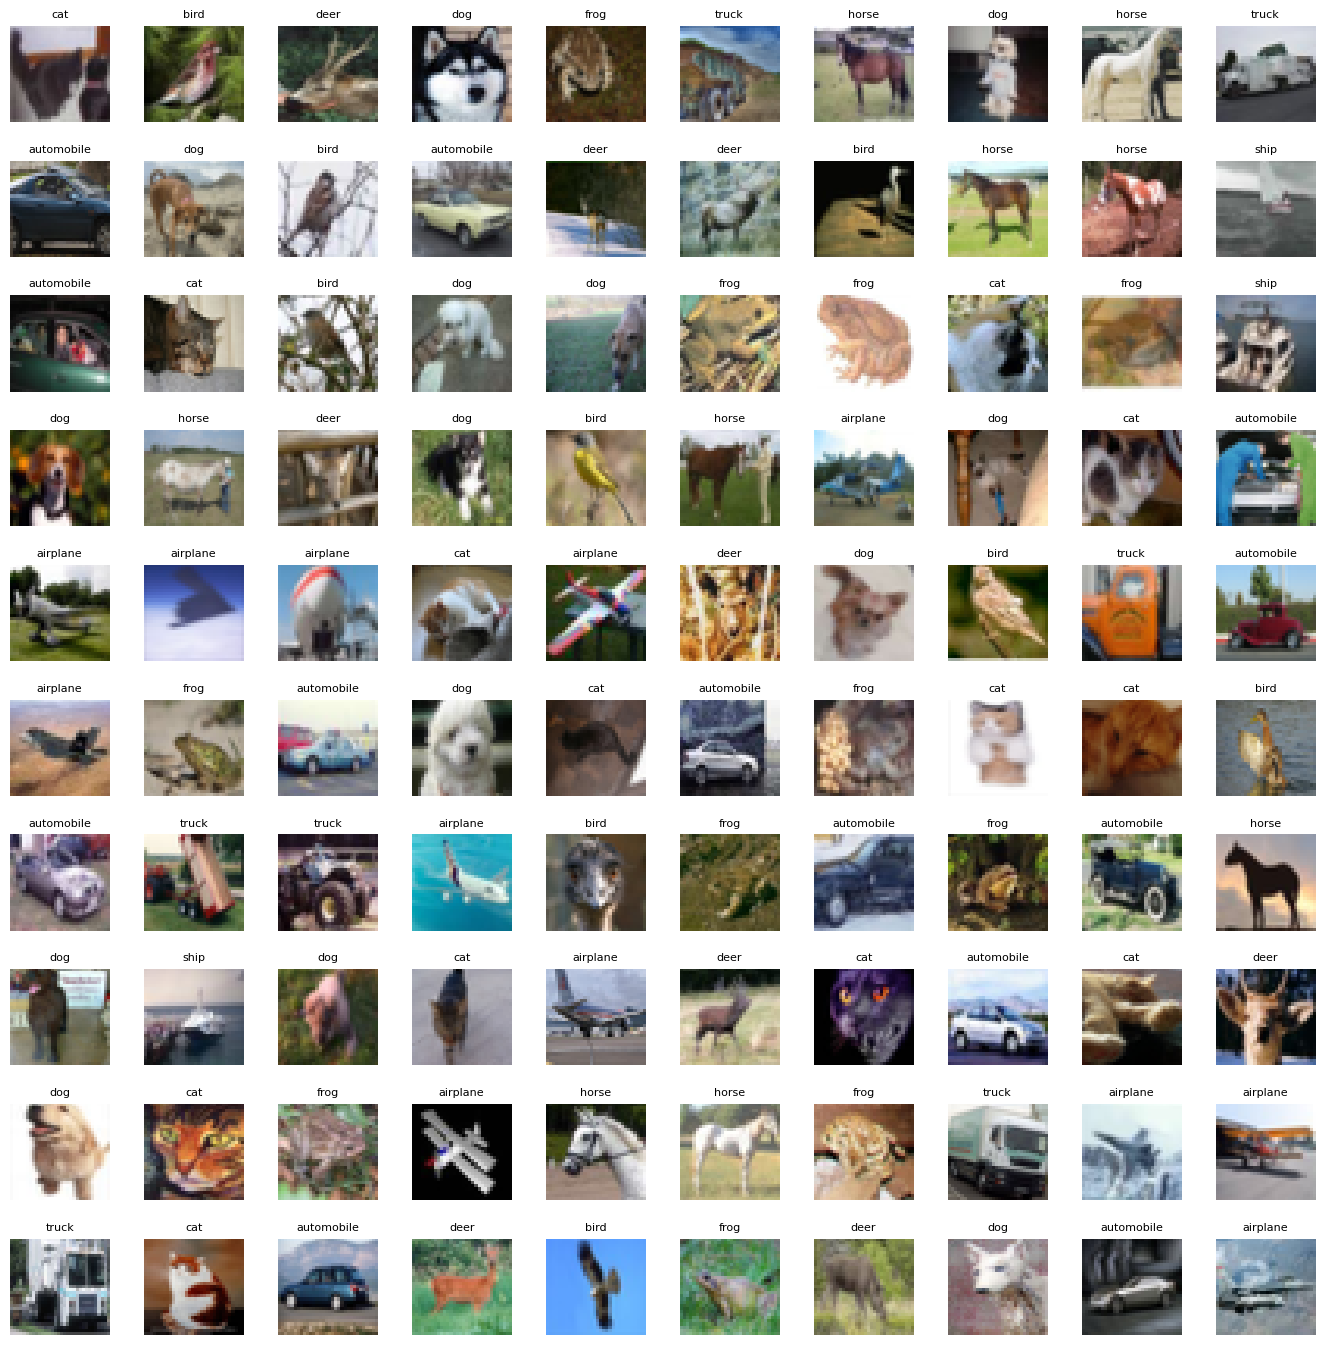

In [4]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 10
L_grid = 10

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(x_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow(x_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Text(0.5, 1.0, 'Class distribution in training set')

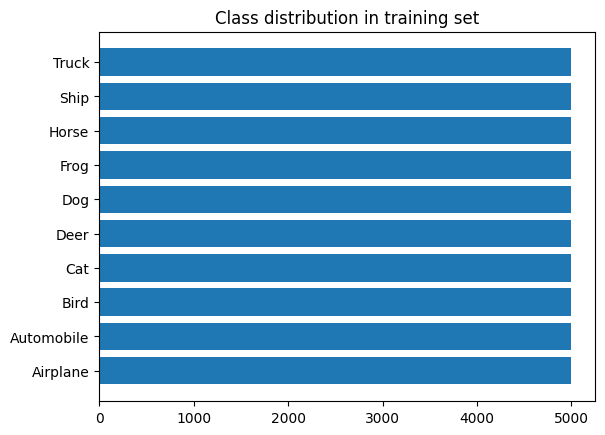

In [5]:
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

classes, counts = np.unique(y_train, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in testing set')

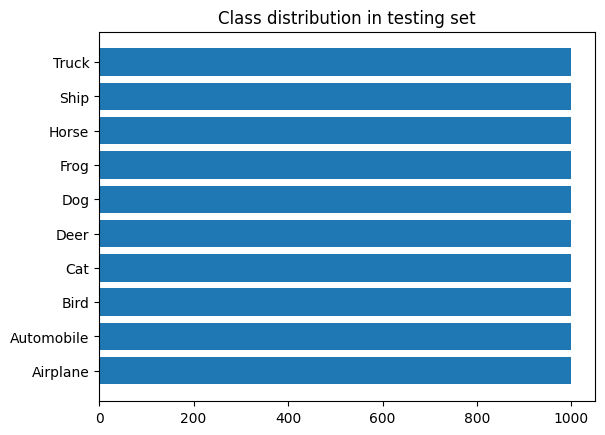

In [6]:
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in testing set')

# Data Preprocessing

In [7]:
# Scale the data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Transform target variable into one-hotencoding
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

print(f"Veri Boyutu: Eğitim ({x_train.shape}), Test ({x_test.shape})")

Veri Boyutu: Eğitim ((50000, 32, 32, 3)), Test ((10000, 32, 32, 3))


In [8]:
y_cat_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

# Model Building

In [9]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(NUM_CLASSES,activation="softmax"))

model.summary()

I0000 00:00:1763490271.504531      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,344,170 (5.13 MB)

 Trainable params: 1,342,698 (5.12 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,344,170 (5.13 MB)

 Trainable params: 1,342,698 (5.12 MB)

 Non-trainable params: 1,472 (5.75 KB)

# Data Augmentations

In [11]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

# Geri Çağrılar (Callbacks)
# Early Stopping: Doğruluk 7 epoch iyileşmezse durdur.
es_callback = EarlyStopping(monitor="val_accuracy",patience=7,restore_best_weights=True)

# Learning rate azaltma: Kayıp 5 epoch iyileşmezse öğrneme oranını 0.5 katına düşür.
lr_scheduler = ReduceLROnPlateau(monitor="val_loss",factor=0.5,patience=5)

model.compile(optimizer="adam",
             loss="categorical_crossentropy",
             metrics=["accuracy"])

# Training Model

In [12]:
EPOCHS = 10
BATCH_SIZE = 64

# DÜZELTME 1: steps_per_epoch toplam örnek sayısının batch size'a bölümü olmalı
steps_per_epoch = x_train.shape[0] // BATCH_SIZE 

print("Model Eğitimi başlatılıyor...")

history = model.fit(
    # DÜZELTME 2: y_train yerine One-Hot kodlanmış y_cat_train kullanılmalı
    datagen.flow(x_train, y_cat_train, batch_size = BATCH_SIZE), 
    
    steps_per_epoch = steps_per_epoch,
    epochs = EPOCHS,
    
    # DÜZELTME 3: y_test yerine One-Hot kodlanmış y_cat_test kullanılmalı
    validation_data = (x_test, y_cat_test), 
    
    callbacks =[es_callback,lr_scheduler],
    verbose=1
)
print("Eğitim tamamlandı.")

Model Eğitimi başlatılıyor...
Epoch 1/10


I0000 00:00:1763490279.223419      73 service.cc:148] XLA service 0x7d4af8019240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763490279.224259      73 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763490279.828137      73 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/781 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.1521 - loss: 3.2960

I0000 00:00:1763490285.078042      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


781/781 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.3422 - loss: 2.0218 - val_accuracy: 0.5468 - val_loss: 1.3014 - learning_rate: 0.0010
Epoch 2/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5469 - loss: 1.3957 - val_accuracy: 0.5451 - val_loss: 1.3042 - learning_rate: 0.0010
Epoch 3/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.5579 - loss: 1.2407 - val_accuracy: 0.5576 - val_loss: 1.4143 - learning_rate: 0.0010
Epoch 4/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7031 - loss: 0.7591 - val_accuracy: 0.5758 - val_loss: 1.3376 - learning_rate: 0.0010
Epoch 5/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.6470 - loss: 1.0015 - val_accuracy: 0.6991 - val_loss: 0.8688 - learning_rate: 0.0010
Epoch 6/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6719 - loss: 0.9902 - val_accuracy: 0.6960 - val_loss: 0.8825 - learning_rate: 0.0010
Epoch 7/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.6799 - loss: 0.9141 - val

# Model Evaluation

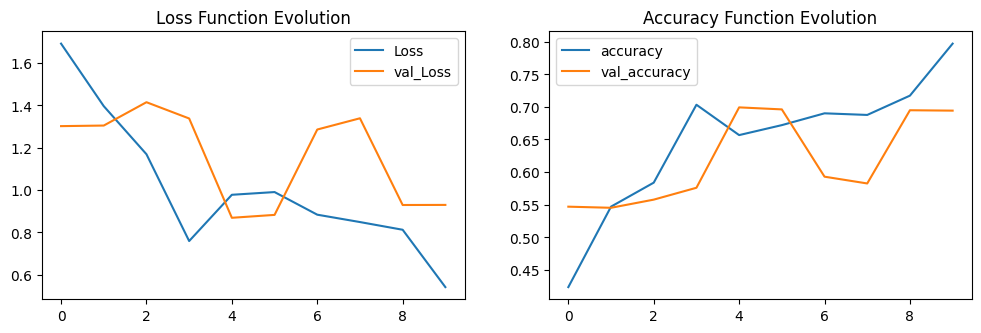

In [13]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6988 - loss: 0.8703
Test Accuracy : 69.91%
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


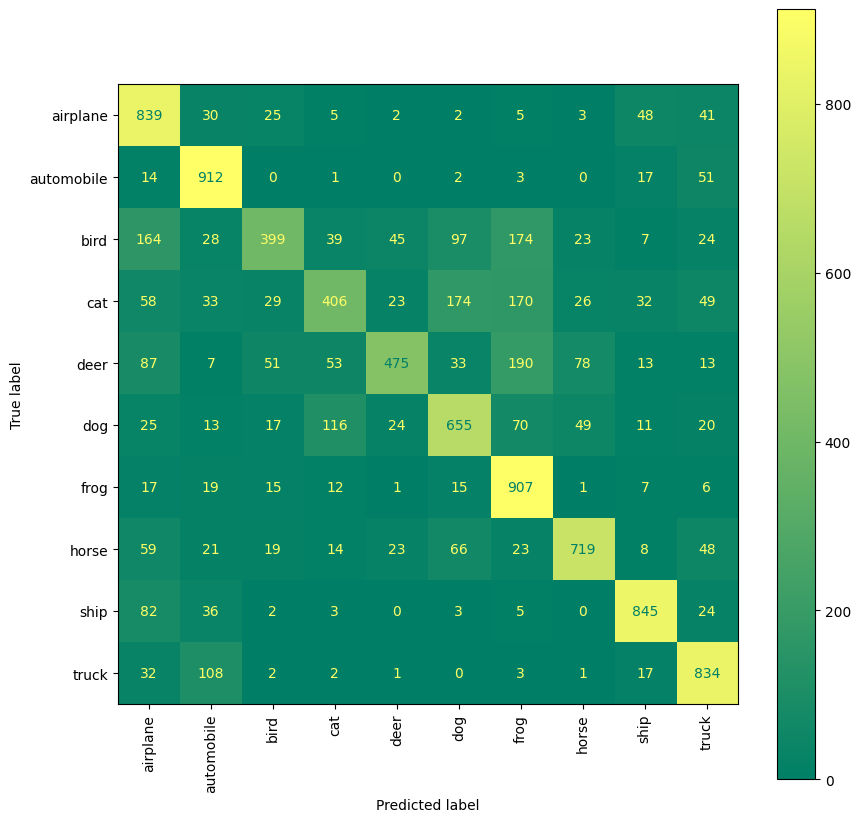

In [14]:
evaluation = model.evaluate(x_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [15]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.61      0.84      0.71      1000
           1       0.76      0.91      0.83      1000
           2       0.71      0.40      0.51      1000
           3       0.62      0.41      0.49      1000
           4       0.80      0.47      0.60      1000
           5       0.63      0.66      0.64      1000
           6       0.59      0.91      0.71      1000
           7       0.80      0.72      0.76      1000
           8       0.84      0.84      0.84      1000
           9       0.75      0.83      0.79      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.69     10000
weighted avg       0.71      0.70      0.69     10000



# Test on one image

 Image 100 is [4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
The model predict that image 100 is 4


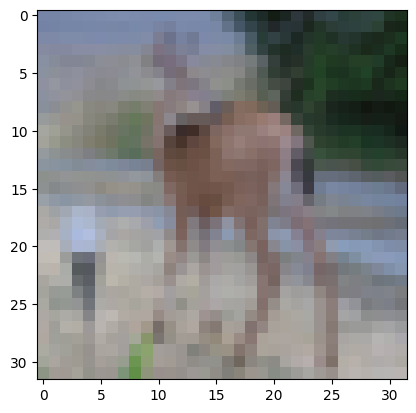

In [16]:
my_image = x_test[100]
plt.imshow(my_image)

# that's a Deer
print(f" Image 100 is {y_test[100]}")

# correctly predicted as a Deer
pred_100 = np.argmax(model.predict(my_image.reshape(1, 32, 32, 3)))
print(f"The model predict that image 100 is {pred_100}")